In [1]:
import pandas as pd
from sdv.single_table import TVAESynthesizer

from domias.evaluator import evaluate_performance
from domias.models.generator import GeneratorInterface
from domias.models.ctgan import CTGAN



from scipy import stats
from scipy.stats import multivariate_normal


import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing, fetch_covtype, load_digits

import warnings
warnings.filterwarnings("ignore")

[KeOps] Warning : 
    The default C++ compiler could not be found on your system.
    You need to either define the CXX environment variable or a symlink to the g++ command.
    For example if g++-8 is the command you can do
      import os
      os.environ['CXX'] = 'g++-8'
    
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [2]:
#Read in UCI dataset
df_uci = pd.read_csv(r'C:/users/jordy/Desktop/Domias_notebooks/df_uci_outliers.csv')



In [3]:
#create 8 different pairs of datasets for comparisons

#Separate outliers and non-outliers into two different dfs, 
#then randomly select 10k for control, and 10k-number outliers and concat

#709 rows
df_outliers = df_uci[df_uci['Outlier']==1]

#29291 rows
df_normals = df_uci[df_uci['Outlier']==0]



In [7]:




#sample_iteration_results={}

for i in range(1,3):
    df = pd.DataFrame()
    normal_sampled_df=df_normals.sample(n=10000)
    normal_sampled_for_outlier_df = df_normals.sample(n=(10000 - df_outliers.shape[0]))
    outlier_incl = pd.concat([normal_sampled_for_outlier_df, df_outliers])
    dataset_list = [normal_sampled_df, outlier_incl]
    for item, sampled_dataset in enumerate(dataset_list):
        #dataset_used = str(sampled_dataset)
        #sampled_dataset.name = ''
        arr_uci = np.array(sampled_dataset.iloc[:, 1:-1])
        
        
        def get_dataset() -> np.ndarray:
            def data_loader() -> np.ndarray:
                scaler = StandardScaler()
                X =arr_uci
                np.random.shuffle(X)
                return scaler.fit_transform(X)

            return data_loader()
        
        def get_generator(
            gan_method: str = "CTGAN",
            epochs: int = 1000,
            seed: int = 0,
        ) -> GeneratorInterface:
            class LocalGenerator(GeneratorInterface):
                def __init__(self) -> None:
                    if gan_method == "TVAE":
                        syn_model = TVAESynthesizer(metadata, epochs=epochs)
                    elif gan_method == "CTGAN":
                        syn_model = CTGAN(epochs=epochs)
                    elif gan_method == "KDE":
                        syn_model = None
                    else:
                        raise RuntimeError()
                    self.method = gan_method
                    self.model = syn_model


                def fit(self, data: pd.DataFrame) -> "LocalGenerator":
                    if self.method == "KDE":
                        self.model = stats.gaussian_kde(np.transpose(data))
                    else:
                        self.model.fit(data)
                    return self

                def generate(self, count: int) -> pd.DataFrame:

                    if gan_method == "KDE":
                        samples = pd.DataFrame(self.model.resample(count).transpose(1, 0))
                    elif gan_method == "TVAE":
                        samples = self.model.sample(count)
                    elif gan_method == "CTGAN":
                        samples = self.model.generate(count)
                    else:
                        raise RuntimeError()

                    return samples

                    #return self.model.sample(count)

            return LocalGenerator()


        #Loading metadata from dataset for use in TVAESynthesizer
        dataset = get_dataset()
        # df_dataset = pd.DataFrame(dataset)
        # df_dataset.rename(columns={0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7'}, inplace = True)

        # from sdv.metadata import SingleTableMetadata

        # metadata = SingleTableMetadata()
        # metadata.detect_from_dataframe(data=df_dataset)






        """
        Args:
            generator: GeneratorInterface
                Generator with the `fit` and `generate` methods. The generator MUST not be fitted.
            dataset: int
                The evaluation dataset, used to derive the training and test datasets.
            training_size: int
                The split for the training (member) dataset out of `dataset`
            reference_size: int
                The split for the reference dataset out of `dataset`.
            training_epochs: int
                Training epochs
            synthetic_sizes: List[int]
                For how many synthetic samples to test the attacks.

        """

        """
        CTGAN Args:

        embedding_dim: int = 128,
        generator_dim: Tuple = (256, 256),
        discriminator_dim: Tuple = (256, 256),
        generator_lr: float = 2e-4,
        generator_decay: float = 1e-6,
        discriminator_lr: float = 2e-4,
        discriminator_decay: float = 1e-6,
        batch_size: int = 500,
        discriminator_steps: int = 1,
        log_frequency: bool = True,
        verbose: bool = False,
        epochs: int = 300,
        pac: int = 1,
        cuda: bool = True,



        """


        # mem_set_size = 1000 -> originally what training size was
        reference_set_size = 100 #held out set
        training_epochs = [500]
        training_sizes = [100, 200]
        #synthetic_sizes = [200]
        density_estimator = "kde"  # prior, kde, bnaf
        gen_size = 200 #same as synthetic_sizes

        method = "CTGAN"

        # Create a dictionary to store the results
        results = {}

        # Set the number of iterations
        num_iterations = 2

        for iteration in range(1, num_iterations+1):
            # Initialize the result dictionary for the current iteration
            iteration_results = {}

            for training_size in training_sizes:
                # Initialize the result dictionary for the current training size
                size_results = {}

                for training_epoch in training_epochs:
                    generator = get_generator(
                        gan_method=method,
                        epochs=training_epoch,
                    )

                    perf = evaluate_performance(
                        generator,
                        dataset,
                        training_size,
                        reference_set_size,
                        training_epochs=training_epoch,
                        synthetic_sizes=[gen_size],
                        density_estimator=density_estimator,
                    )

                    # Store the MIA performance for the current training size and epoch
                    size_results[training_epoch] = perf[gen_size]["MIA_performance"]

                # Store the results for the current training size
                iteration_results[training_size] = size_results

            # Store the results for the current iteration
            results[iteration] = iteration_results



            reference_set_size = reference_set_size
            training_size = training_sizes[0]
            gen_size = gen_size

            output = pd.DataFrame([], columns=["sample_iteration","sampled_dataset","iteration", "epoch", "training_size", "reference_size", "gen_size,", "src", "aucroc"])

            for iteration in range(1, num_iterations + 1):
                for training_epoch in training_epochs:
                    epoch_res = results[iteration][training_size][training_epoch]
                    perf = epoch_res  # Assuming perf is the correct value for accuracy

                    for key in perf:
                        output = pd.concat(
                            [
                                output,
                                pd.DataFrame(
                                    [
                                        [i, item, iteration, training_epoch, training_size, reference_set_size, gen_size, key, perf[key]["aucroc"]]
                                    ],
                                    columns=["sample_iteration","sampled_dataset","iteration", "epoch", "training_size", "reference_size", "gen_size,", "src", "aucroc"],
                                ),
                            ]
                        )    

            output.to_csv(f'{item}_sample_{i}_iteration_{iteration}.csv')

            
#         # Print the results
#         for iteration, iteration_results in results.items():
#             print(f"Iteration {iteration}:")
#             for training_size, size_results in iteration_results.items():
#                 print(f"Training Size {training_size}:")
#                 for training_epoch, mia_performance in size_results.items():
#                     print(f"Training Epoch {training_epoch}: MIA Performance = {mia_performance}")
#                 print()


p_G_evaluated
[3.73142271e-010 5.42970803e-011 3.41691420e-011 2.80448664e-011
 1.67478952e-013 2.96153324e-018 1.76642435e-011 8.22518377e-012
 2.15993777e-011 2.33158305e-010 2.02244318e-012 2.35633924e-013
 1.80787460e-016 2.49802338e-012 6.74989671e-015 5.19042610e-011
 3.76018810e-013 6.79419568e-015 9.68144808e-016 2.19716206e-018
 1.19816746e-014 8.48622525e-014 7.67193481e-011 4.40074748e-018
 8.75383696e-011 9.11220266e-011 3.56901008e-013 4.04610889e-016
 7.58786182e-010 2.34938820e-019 6.93679385e-015 1.89159496e-013
 3.66997204e-011 9.42796688e-014 2.12276962e-011 5.67656161e-017
 4.31611525e-011 2.29939972e-010 2.88201642e-010 3.85877022e-011
 1.54292906e-010 1.57606722e-014 7.53500022e-012 9.00381172e-012
 2.06425149e-014 7.59232497e-028 6.39424905e-015 1.84078080e-026
 7.51117976e-015 1.91613868e-012 7.64601889e-011 9.06266718e-014
 2.75928282e-027 1.75886667e-014 6.54267431e-014 1.46785348e-011
 5.99684796e-013 1.10797734e-014 3.27628933e-253 5.78278512e-012
 7.10266020

p_G_evaluated
[1.95633642e-011 4.68347819e-011 9.94651465e-012 2.07746999e-011
 3.90849595e-014 2.35188741e-017 4.06245338e-012 1.24139232e-012
 5.50222235e-014 1.34663601e-010 1.24001296e-009 8.96870427e-011
 8.07179307e-012 1.32268281e-013 6.96443910e-017 6.80987758e-012
 1.48210069e-011 3.78052002e-015 1.45696998e-015 7.16780351e-015
 1.32529671e-012 1.92679548e-012 4.88019390e-011 3.05541989e-013
 4.31509004e-011 4.66800336e-011 8.64188804e-013 1.06992962e-013
 2.85407118e-010 1.10460575e-016 5.42913007e-016 2.58117183e-016
 3.02658733e-011 1.34094245e-013 1.37474888e-011 6.99212788e-026
 1.17907828e-011 5.50262860e-011 1.96359297e-011 6.74591187e-011
 1.73609440e-010 1.43670593e-011 1.28466425e-013 5.03981038e-012
 2.86274691e-012 1.91319123e-058 5.75247513e-015 1.41422531e-056
 3.15898361e-012 8.07732064e-012 2.46316779e-010 1.46650105e-013
 8.33128940e-020 1.31312243e-018 6.42632849e-013 1.71662008e-011
 5.59365298e-012 3.00071948e-013 1.19071917e-253 2.83593094e-010
 1.56164212

KeyError: 2

In [40]:
df_0_0 = pd.read_csv('0_sample_0_iteration_1.csv', index_col=0)
df_1_0 = pd.read_csv('1_sample_0_iteration_1.csv', index_col=0)

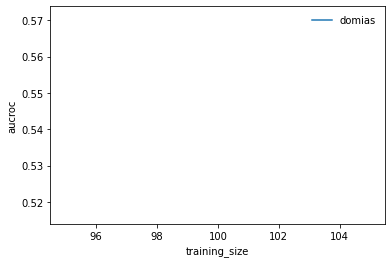

In [32]:
from matplotlib import pyplot as plt
import seaborn as sns

#With unique legend
fig, ax = plt.subplots()

for iteration in range(1, num_iterations + 1):
    sns.lineplot(data=a, x="training_size", y="aucroc", hue="src", ax=ax, legend=False)

ax.legend(labels = ['domias'], frameon=False)
plt.show()

In [41]:
df_0_0[df_0_0['src']=='domias']

,sample_iteration,sampled_dataset,iteration,epoch,training_size,reference_size,"gen_size,",src,aucroc
0,0,0,1,500,100,100,200,domias,0.5739


In [42]:
df_1_0[df_1_0['src']=='domias']

,sample_iteration,sampled_dataset,iteration,epoch,training_size,reference_size,"gen_size,",src,aucroc
0,0,1,1,500,100,100,200,domias,0.5082


In [ ]:


# Set the number of iterations
num_iterations = 2

for i in range(1, num_iterations + 1):
    df = pd.DataFrame()
    normal_sampled_df = df_normals.sample(n=10000)
    normal_sampled_for_outlier_df = df_normals.sample(n=(10000 - df_outliers.shape[0]))
    outlier_incl = pd.concat([normal_sampled_for_outlier_df, df_outliers])
    dataset_list = [normal_sampled_df, outlier_incl]

    for item, sampled_dataset in enumerate(dataset_list):
        arr_uci = np.array(sampled_dataset.iloc[:, 1:-1])

        def get_dataset() -> np.ndarray:
            def data_loader() -> np.ndarray:
                scaler = StandardScaler()
                X = arr_uci
                np.random.shuffle(X)
                return scaler.fit_transform(X)

            return data_loader()

        def get_generator(
            gan_method: str = "CTGAN",
            epochs: int = 1000,
            seed: int = 0,
        ) -> GeneratorInterface:
            class LocalGenerator(GeneratorInterface):
                def __init__(self) -> None:
                    if gan_method == "TVAE":
                        syn_model = TVAESynthesizer(metadata, epochs=epochs)
                    elif gan_method == "CTGAN":
                        syn_model = CTGAN(epochs=epochs)
                    elif gan_method == "KDE":
                        syn_model = None
                    else:
                        raise RuntimeError()
                    self.method = gan_method
                    self.model = syn_model

                def fit(self, data: pd.DataFrame) -> "LocalGenerator":
                    if self.method == "KDE":
                        self.model = stats.gaussian_kde(np.transpose(data))
                    else:
                        self.model.fit(data)
                    return self

                def generate(self, count: int) -> pd.DataFrame:
                    if gan_method == "KDE":
                        samples = pd.DataFrame(self.model.resample(count).transpose(1, 0))
                    elif gan_method == "TVAE":
                        samples = self.model.sample(count)
                    elif gan_method == "CTGAN":
                        samples = self.model.generate(count)
                    else:
                        raise RuntimeError()

                    return samples

            return LocalGenerator()

        # Loading metadata from dataset for use in TVAESynthesizer
        dataset = get_dataset()

        reference_set_size = 100
        training_epochs = [500]
        training_sizes = [100, 200]
        density_estimator = "kde"  # prior, kde, bnaf
        gen_size = 200

        method = "CTGAN"

        # Create a dictionary to store the results
        results = {}

        for iteration in range(1, num_iterations + 1):
            # Initialize the result dictionary for the current iteration
            iteration_results = {}

            for training_size in training_sizes:
                # Initialize the result dictionary for the current training size
                size_results = {}

                for training_epoch in training_epochs:
                    generator = get_generator(
                        gan_method=method,
                        epochs=training_epoch,
                    )

                    perf = evaluate_performance(
                        generator,
                        dataset,
                        training_size,
                        reference_set_size,
                        training_epochs=training_epoch,
                        synthetic_sizes=[gen_size],
                        density_estimator=density_estimator,
                    )

                    # Store the MIA performance for the current training size and epoch
                    size_results[training_epoch] = perf[gen_size]["MIA_performance"]

                # Store the results for the current training size
                iteration_results[training_size] = size_results

            # Store the results for the current iteration
            results[iteration] = iteration_results

        output = pd.DataFrame([], columns=["sample_iteration", "sampled_dataset", "iteration", "epoch", "training_size", "reference_size", "gen_size,", "src", "aucroc"])

        for iteration in range(1, num_iterations + 1):
            for training_epoch in training_epochs:
                epoch_res = results[iteration][training_sizes[0]][training_epoch]
                perf = epoch_res  # Assuming perf is the correct value for accuracy

                for key in perf:
                    output = pd.concat(
                        [
                            output,
                            pd.DataFrame(
                                [
                                    [i, item, iteration, training_epoch, training_sizes[0], reference_set_size, gen_size, key, perf[key]["aucroc"]]
                                ],
                                columns=["sample_iteration", "sampled_dataset", "iteration", "epoch", "training_size", "reference_size", "gen_size", "src", "aucroc"],
                            ),
                        ]
                    )

        output.to_csv(f'{item}_sample_{i}_iteration_{iteration}.csv')


p_G_evaluated
[2.56178408e-015 8.33152189e-009 1.69495598e-008 6.25688796e-013
 3.99164817e-013 8.38996761e-010 1.64581916e-008 6.10434961e-009
 2.34426362e-010 2.06101326e-009 9.14122123e-011 3.64615585e-010
 1.33814155e-016 6.69643198e-011 1.48345851e-010 1.23032815e-008
 5.42843558e-011 2.30917522e-017 1.07474430e-008 2.29584366e-009
 1.98341676e-009 2.36522056e-009 2.42479347e-010 3.12347610e-014
 7.70490021e-010 6.73282067e-014 5.16091179e-017 1.91048296e-009
 4.47215350e-010 1.45304389e-009 6.94395391e-011 1.05671163e-011
 5.37869258e-010 1.66640234e-012 7.71531844e-011 5.84324393e-010
 1.22535183e-008 2.01658577e-009 1.50496482e-011 1.21550900e-048
 9.12406238e-009 7.76518994e-015 1.09359629e-010 2.24202324e-020
 8.64858859e-009 1.60504961e-011 3.03576373e-009 7.55700804e-009
 1.06150068e-009 1.13753722e-015 1.24720566e-010 1.67508851e-028
 6.45194505e-009 1.58823598e-009 2.92222214e-014 5.42307964e-016
 2.50749097e-026 1.06156772e-010 1.39634835e-008 1.15719430e-029
 1.26862088

p_G_evaluated
[1.06567266e-014 8.60842396e-010 6.83185093e-010 2.81200951e-015
 1.24955713e-022 1.33103082e-011 2.80996322e-009 5.45677743e-010
 2.03637052e-011 1.04961624e-009 2.92444575e-013 3.08235278e-010
 6.00699738e-026 6.47528206e-011 8.29886435e-011 3.42016966e-010
 1.00033364e-010 5.54891915e-016 1.33467085e-011 9.82810956e-010
 1.81952550e-010 1.38446325e-010 1.80195406e-011 2.52991788e-013
 4.15061166e-010 1.03076532e-013 9.94387491e-014 2.81738934e-010
 1.10668411e-011 2.89267146e-009 2.46684572e-012 3.85624070e-012
 3.08810920e-009 4.70727879e-015 8.05772600e-012 1.17682650e-011
 9.37550272e-010 1.55168094e-010 7.20667390e-010 2.00007468e-015
 2.66686089e-009 2.08552689e-012 6.24195824e-015 2.03096286e-019
 8.91370881e-010 8.82054382e-010 2.15623656e-009 1.49671856e-009
 8.10661325e-011 1.38482647e-011 4.51560206e-011 5.10926624e-013
 1.71331634e-011 1.32926383e-010 1.06111937e-012 6.16605072e-021
 6.86926995e-029 1.06932702e-014 1.49366642e-009 8.13049554e-028
 6.94343733

p_G_evaluated
[4.57677605e-014 2.71530660e-009 3.89581407e-007 5.96213620e-012
 6.21510163e-019 6.75389641e-010 2.57680893e-007 3.39291551e-009
 4.19765580e-010 2.82065116e-009 1.74247853e-014 7.74131903e-010
 5.97996732e-269 8.94544510e-009 4.39282614e-009 3.09600799e-007
 6.26538108e-011 2.45253736e-015 7.02698436e-008 2.03397863e-009
 3.02994054e-006 1.11343405e-007 1.08167282e-009 4.81575262e-014
 1.47150134e-007 5.64730222e-012 9.96466580e-019 2.83969658e-007
 2.47845890e-010 1.61712408e-008 1.92589005e-011 4.75278819e-011
 1.86130041e-008 3.44426066e-017 2.46337331e-009 4.21169086e-009
 2.27707560e-007 6.10481666e-007 1.48847693e-008 4.46650116e-021
 5.39472038e-007 1.14822236e-013 1.89414807e-013 1.23098375e-021
 3.98805913e-008 3.92817598e-009 7.36664427e-007 1.81622082e-007
 6.52249926e-008 3.01807263e-019 2.89718893e-010 2.72727698e-016
 4.33660289e-007 5.44031025e-008 1.56336104e-013 2.32758444e-010
 9.11919044e-045 1.57145979e-009 4.58929568e-007 2.78324722e-028
 2.59069009

p_G_evaluated
[1.61469333e-014 2.24682426e-008 4.15563969e-010 1.36532828e-014
 1.88400489e-013 1.08445852e-009 7.32272432e-009 8.99395558e-009
 3.08686540e-011 4.44971929e-011 2.87235951e-011 8.79639747e-011
 1.35350382e-030 1.29200786e-009 1.64962666e-011 2.15123605e-010
 6.55404278e-012 9.83734828e-016 3.64268866e-010 9.78852017e-009
 7.96968056e-010 1.80772411e-010 4.89252568e-010 9.96456848e-017
 4.61105761e-010 5.07824717e-013 8.42027952e-019 4.05814747e-010
 7.27014766e-012 1.68203374e-008 1.93173190e-009 2.12049066e-010
 2.64001461e-010 1.92177400e-013 3.79770357e-011 1.79152977e-010
 2.21759817e-009 3.60759652e-010 5.97239620e-010 1.59770691e-014
 3.91838561e-009 2.18494876e-015 6.86873245e-012 2.87312378e-018
 5.60655109e-010 6.54927823e-014 9.22049148e-010 4.87090429e-009
 4.53230667e-010 3.18811528e-014 7.42491945e-012 2.87364311e-012
 5.16503121e-010 3.85094134e-010 3.60696815e-012 3.06054610e-014
 4.38598625e-030 1.36732091e-014 4.50778700e-010 1.03299835e-025
 4.89552686

p_G_evaluated
[4.56616625e-010 5.28037268e-011 9.56325503e-010 1.15455614e-017
 5.45638101e-012 3.37568293e-012 1.24102224e-013 3.80685413e-012
 7.56138134e-014 8.72727161e-014 1.87473508e-011 1.94017030e-012
 4.62600965e-013 6.61219639e-016 5.69344708e-011 5.87225596e-011
 2.99691727e-019 5.16612783e-032 1.47229538e-012 1.79070492e-013
 1.10989899e-010 8.32628155e-015 0.00000000e+000 1.91858126e-012
 9.36189808e-013 2.39461224e-010 3.21545947e-011 3.28466315e-014
 5.31972464e-019 6.21051212e-014 6.39991282e-016 2.69396501e-011
 5.22301040e-015 6.01939516e-011 1.35704363e-011 1.99233386e-011
 7.29425983e-012 3.60825335e-011 5.09430350e-013 3.07677231e-010
 3.69652116e-011 2.47587914e-018 1.26535387e-009 2.80532884e-012
 2.16248646e-013 3.06026269e-011 1.20032823e-010 7.59701750e-011
 4.51325963e-011 5.92714599e-013 5.85479612e-013 2.03695280e-012
 1.46066693e-017 1.42713659e-018 1.45873177e-012 4.47520519e-010
 3.94468468e-021 5.31841953e-013 1.32925366e-012 3.94714469e-013
 7.40124382

p_G_evaluated
[3.77773513e-011 1.26700534e-011 1.23006679e-008 1.79507471e-078
 3.36667921e-012 7.77606914e-013 1.74607586e-011 7.65705453e-011
 6.74985097e-016 1.46902821e-019 1.55593922e-009 1.78060272e-010
 4.01380219e-014 4.83429931e-027 3.69537608e-010 2.06696651e-009
 8.52671629e-016 4.10707099e-035 1.05317968e-011 6.09846963e-012
 7.84311918e-010 6.80378284e-016 0.00000000e+000 5.69981594e-012
 4.77849227e-012 2.05586216e-010 3.77888408e-009 2.83990293e-014
 3.00985002e-012 7.72376169e-012 2.73582435e-014 1.11500874e-009
 8.49720586e-012 1.41484777e-009 1.83871099e-009 8.52502244e-009
 2.06112659e-009 1.35901551e-008 8.85345418e-012 1.47575997e-009
 3.29391082e-014 1.14764049e-016 3.93611416e-010 2.67612328e-011
 2.66471676e-013 6.42056011e-011 6.82029796e-010 3.02765226e-009
 1.67999737e-009 2.59636920e-011 2.56998670e-011 1.03607744e-010
 1.72972941e-014 2.27790327e-013 3.15939171e-012 2.69975799e-010
 3.78326848e-021 2.82166957e-012 7.83678576e-010 4.97332701e-014
 4.32142815

p_G_evaluated
[1.74041386e-010 3.23341535e-012 3.81130753e-010 4.87079711e-017
 1.08870389e-012 1.30741483e-012 2.04947214e-011 3.75318410e-010
 6.55909789e-015 8.66047831e-014 5.59111873e-012 2.97630371e-013
 2.62151434e-014 6.31142155e-021 7.28354050e-011 1.58808307e-009
 1.14066918e-015 6.84915157e-038 8.61092150e-012 1.55834829e-016
 2.27150020e-010 9.81842341e-021 0.00000000e+000 8.83422356e-012
 2.24032685e-015 1.29790355e-011 8.48635972e-011 1.64951561e-015
 1.47087604e-020 9.16667665e-013 5.87370765e-014 1.03048917e-010
 6.43342100e-011 4.93039383e-011 1.72369877e-012 1.94968941e-009
 8.84580888e-010 1.91532632e-010 2.01394677e-014 2.60710662e-009
 2.95739677e-013 5.50190993e-028 1.86666720e-009 2.03445420e-012
 8.23334574e-011 3.29352622e-011 1.27030434e-010 1.39793488e-010
 1.08384939e-011 6.44703781e-013 1.48501807e-012 2.93368772e-013
 2.74914105e-014 5.72006336e-014 5.19667448e-013 1.43976362e-009
 2.25090156e-023 4.85056355e-012 2.97545611e-011 2.43105643e-012
 2.10649702